<a href="https://colab.research.google.com/github/AshOne91/PLAYDATA-COLAB/blob/main/%EC%84%9C%ED%8F%AC%ED%8A%B8_%EB%B0%B1%ED%84%B0_%EB%A8%B8%EC%8B%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

앙상블
```
배깅(Bagging)
데이터를 무작위로 뽑아서(부트스트랩) 여러모델(결정트리)을 만들고 결과를 평균(회귀) 다수결(분류)로 합치는 방법
대표모델 : RandomForest
T : 모델개수
ht(x) : t번째 모델 예측
```
$$\hat{y} = \frac{1}{T} \sum_{t=1}^{T} h_t(x)$$

```
부스팅(Boosting)
여러개의 학습기를 순차적으로 학습시키면서 이전모델의 오차를 줄이는 방식
Gradient Boosting, AdaBoost, XGBoost
```
```
스태킹
여러개의 모델이 예측한 값들을 다시 메타모델이 학습
ex) 로지스틱 회귀
```
$$\hat{y} = g(h_1(x), h_2(x), \dots, h_T(x))$$

```
투표(Voting)
소프트 보팅 : 확률 평균으로 결정
하드 보팅 : 다수결
```

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
# 결측치 제거
df.dropna(inplace=True)
X = df.drop(columns=['PassengerId','Survived'])
y = df['Survived']
X = X.select_dtypes(exclude='object')
ss = StandardScaler()
X = ss.fit_transform(X)

# z-score 방식으로 이상치 제거
import seaborn as sns
# sns.boxplot(data=df, x='Fare')
from scipy.stats import zscore
temp = zscore(df['Fare'])
df = df[(temp > -3) & (temp < 3)]

X = df.drop(columns=['PassengerId','Survived'])
y = df['Survived']
X = X.select_dtypes(exclude='object')
# 연속형데이터를 범주형으로 벼경
X['Age'] = pd.cut(X['Age'],bins=3,labels=[0,1,2])
X['Family_count'] = X['SibSp'] + X['Parch'] + 1
X.drop(columns=['SibSp','Parch'],inplace=True)
X['Fare'] = pd.cut(X['Fare'],bins=3,labels=[0,1,2])
# 원핫
X = pd.concat([X,pd.get_dummies(df['Sex']).astype(int)], axis=1)
X = pd.concat([X,pd.get_dummies(df['Embarked']).astype(int)], axis=1)

X['IsCabin'] = df['Cabin'].notnull().astype(int)
ss = StandardScaler()
X = ss.fit_transform(X)

앙상블

In [ ]:
!pip install catboost
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 53.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
# 배깅
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from xgboost import XGBClassifier
import numpy as np

kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
rfc = RandomForestClassifier(random_state=42,n_estimators=100,max_depth=3)
rfc.fit(X,y)
scores = cross_validate(rfc, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))

#부스팅
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),random_state=42,n_estimators=100)
scores = cross_validate(abc, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))
# 그래디언트 부스팅
gb = GradientBoostingClassifier(random_state=42,n_estimators=100,max_depth=3)
scores = cross_validate(gb, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))
# XGBoost
xgb = XGBClassifier(random_state=42,n_estimators=100,max_depth=3)
scores = cross_validate(xgb, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))
# 스태킹
from sklearn.neighbors import KNeighborsClassifier
estimators = [
    ('rf',RandomForestClassifier(n_estimators=100,max_depth=3,random_state=42)),
    ('xgb',XGBClassifier(n_estimators=100,max_depth=3,random_state=42)),
    ('knn',KNeighborsClassifier())   ,
    ('ada',AdaBoostClassifier(n_estimators=100,random_state=42)),
    ('db',GradientBoostingClassifier(n_estimators=100,max_depth=3,random_state=42)),
]
metamodel = VotingClassifier(estimators=estimators,voting='soft')
metamodel.fit(X,y)
scores = cross_validate(metamodel, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))


# 실제 구현
from sklearn.linear_model import LogisticRegression
metamodel = RandomForestClassifier(random_state=42)
# 1. 개별모델의 예측 생성(교차검증이용)
kf = StratifiedKFold(n_splits=5, shuffle=True)
train_meta_features = np.zeros((X.shape[0],len(estimators))) # 메타데이터 특성
from sklearn.model_selection import cross_val_predict
for i,(name,model) in enumerate(estimators):
  # train_meta_features[:,i] =  cross_val_predict(model,X,y,cv=kf,method='predict_proba')[:,0]
  train_meta_features[:,i] =  cross_val_predict(model,X,y,cv=kf,method='predict')
# 2. 메타모델 학습
metamodel.fit(train_meta_features,y)
# 3. 최종 예측
scores = cross_validate(metamodel, train_meta_features, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))

0.7626126126126126
0.7292792792792793
0.7456456456456456
0.7013513513513513
0.7403903903903905
0.762012012012012


In [ ]:
train_meta_features

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0.],
       [1., 0., 1., 1., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1.

서포트 벡터 머신
```
SVM : 두 클래스(사망/생존)을 나누는 선을 찾음
이 선이 클래스 사이의 간격(마진)을 최대한 크게 만드는 목표
결정경계 : 두 클래스를 나누는선 또는 평면
마진 : 결정경계와 가장 가까운 데이터 포인트(Support Vector)  사이의 거리가 클수록 안정적인 모델
```

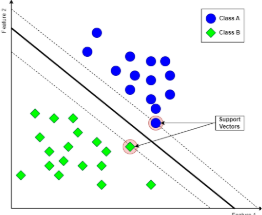

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')

scores = cross_validate(svc, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))

0.7510510510510511


비지도 학습

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# 데이터
!wget https://bit.ly/fruits_300_data -O fruits_300.npy
fruits = np.load('fruits_300.npy')

--2025-03-28 01:46:30--  https://bit.ly/fruits_300_data
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy [following]
--2025-03-28 01:46:30--  https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy [following]
--2025-03-28 01:46:30--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

In [ ]:
fruits.shape

(300, 100, 100)

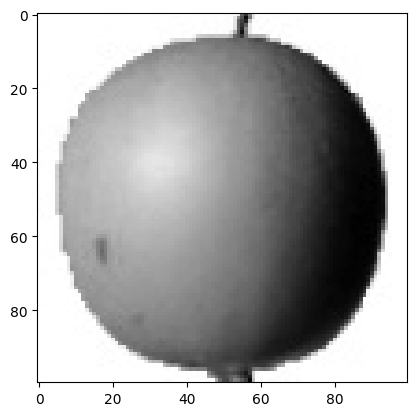

In [ ]:
import matplotlib.pyplot as plt
# fruits[0,50] = 0
plt.imshow(fruits[0], cmap='gray_r')
plt.show()

k-means k평균
```
데이터를 비슷한 특징으로 가진그룹(클러스터)로 나누는 비지도 학습법
목적함수
각 데이터포인트가 자신이 속한 클러스터의 중심점까지의 거리 제곱의 총합 , 값이 작을수도록 잘 모여있다
```
$$J = \sum_{i=1}^{n} \sum_{k=1}^{K} r_{ik} ||x_i - \mu_k||^2$$

```
중심점 업데이트
```
$$\mu_k = \frac{\sum_{i=1}^{n} r_{ik} x_i}{\sum_{i=1}^{n} r_{ik}}$$


In [ ]:
print(fruits.shape)
fruits_2d = fruits.reshape(-1,100*100)

(300, 100, 100)


In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, random_state=42)
km.fit(fruits_2d)
print(km.labels_)

[2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 3 3 3 3 1 3 1 1 3 3 3 3 1 1 1 1 3 1 1
 3 3 3 3 3 3 3 1 3 3 3 1 3 1 3 3 3 3 1 1 3 3 3 1 3 3 3 1 3 3 3 1 3 3 3 3 1
 3 3 3 1 3 3 3 3 1 3 3 3 1 1 0 3 3 3 1 1 3 3 3 1 3 3 3 3 1 1 3 3 3 3 1 1 1
 1 3 1 3]


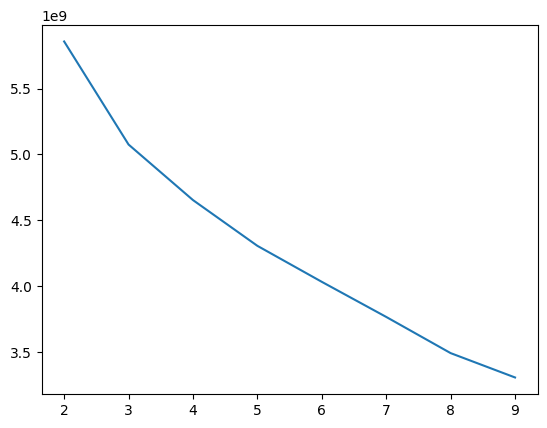

In [ ]:
temp = []
for k in range(2,10):
  kn = KMeans(n_clusters=k, random_state=42)
  kn.fit(fruits_2d)
  temp.append(kn.inertia_)  # inertia_ 목적함수의 값
plt.plot(range(2,10),temp)
plt.show()

<ipython-input-100-62600a00d65e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_fare.dropna(inplace=True)


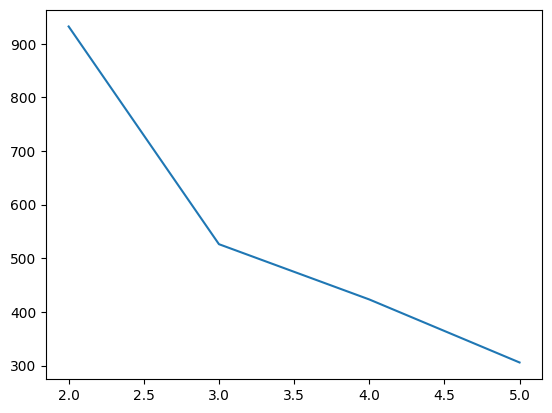

클러스터 중심점....
        나이       요금
클러스터_1 : [0.06908524 3.16238949]
클러스터_2 : [-0.58445172 -0.30479836]
클러스터_3 : [ 1.06849506 -0.03063012]


In [ ]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# 타이타닉 적용 - 군집
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
# 나이와 요금사이의 군집관계
# 1. 나이와 요금데이터만 추출
df_age_fare = df[['Age','Fare']]
# 2. 결측치와 이상치 처리
df_age_fare.dropna(inplace=True)
# sns.boxplot(data=df_age_fare)
df_age_fare = df_age_fare[df_age_fare['Fare']<=400]
# 3. 스케일링
ss = StandardScaler()
df_age_fare =  ss.fit_transform(df_age_fare)
# 4. k-means 적용
inertia = []
for k in range(2,6):
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(df_age_fare)
  inertia.append(km.inertia_)
plt.plot(range(2,6), inertia  )
plt.show()
# 5. 적합한 클러스터의 개수 확인 및 적용(엘보우)
km = KMeans(n_clusters=3, random_state=42)
km.fit(df_age_fare)
# 6. 클러스터의 중심점 출력 모델.cluster_centers_
print('클러스터 중심점....')
print('        나이       요금')
for idx, cluster_center in enumerate(km.cluster_centers_):
  print(f'클러스터_{idx+1} : {cluster_center}')

In [ ]:
ss.inverse_transform(km.cluster_centers_)

array([[ 30.68      , 168.39080909],
       [ 21.176097  ,  19.59897921],
       [ 45.21367521,  31.36470855]])

# 이미지 분류  시스템 (클러스터링 )
# 이미그룹에서 같은 이미지만 분류해서 폴더도 자동생성
# 같은 이미지는 같은 폴더에 저장

In [ ]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

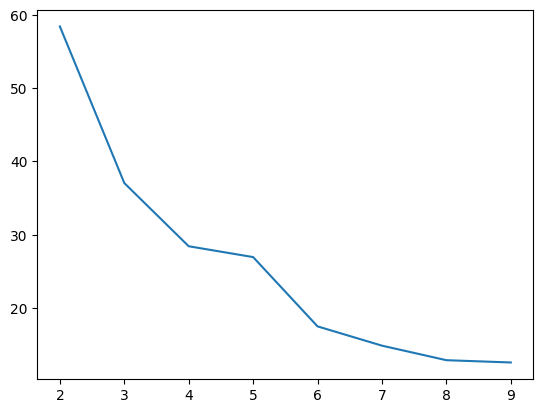

In [ ]:
iris = load_iris()
datas = iris.data[:,:2]
inertia = []
for k in range(2,10):
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(datas)
  inertia.append(km.inertia_)
plt.plot(range(2,10),inertia)
plt.show()


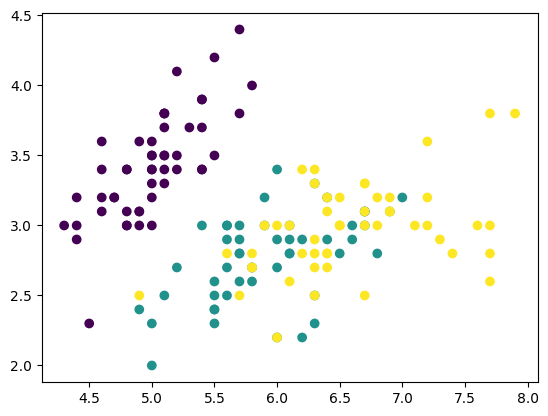

In [ ]:
plt.scatter(datas[:,0], datas[:,1],c=iris.target)
plt.show()

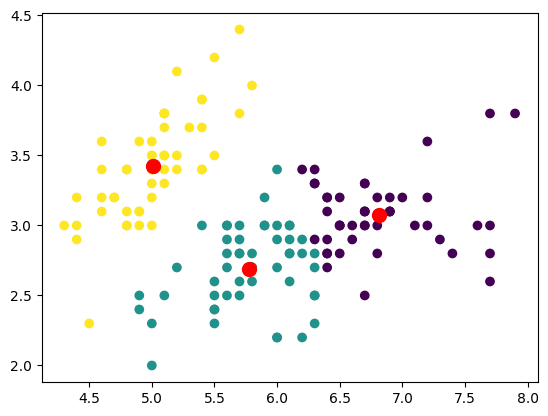

In [ ]:
km = KMeans(n_clusters=3, random_state=42)
km.fit(datas)
len(km.labels_)
plt.scatter(datas[:,0], datas[:,1],c=km.labels_)
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=100,c='red')
plt.show()

```
이미지를 분류 군집분석
1. 데이터(실제 이미지)  
2. 크기가 다양함 -> 동일한 사이즈로 조정
3. 이미지를 넘파이로 변환
4. 군집분석에 적용
```

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())
digits.data.shape

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


(1797, 64)

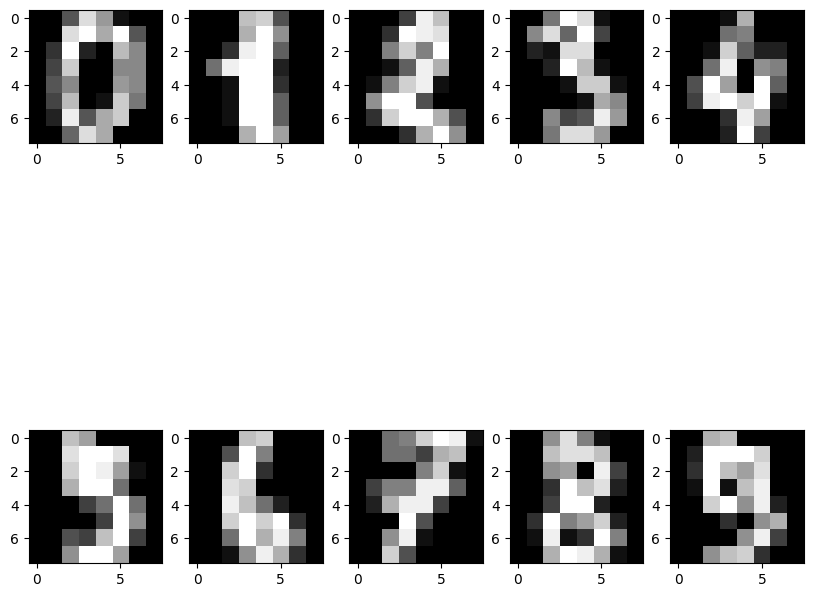

In [ ]:
plt.figure(figsize=(10,10))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(digits.images[i], cmap='gray')
plt.show()

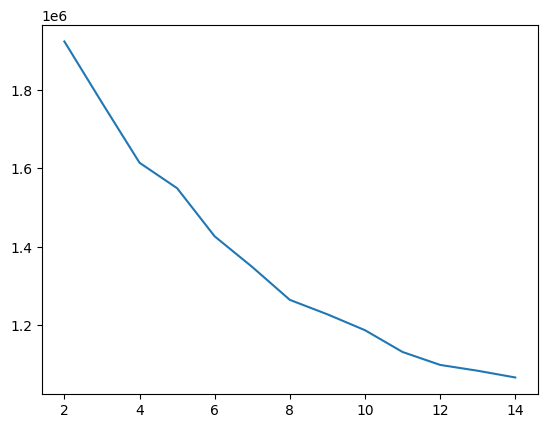

In [ ]:
inertia = []
for k in range(2,15):
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(digits.data)
  inertia.append(km.inertia_)
plt.plot(range(2,15),inertia)
plt.show()

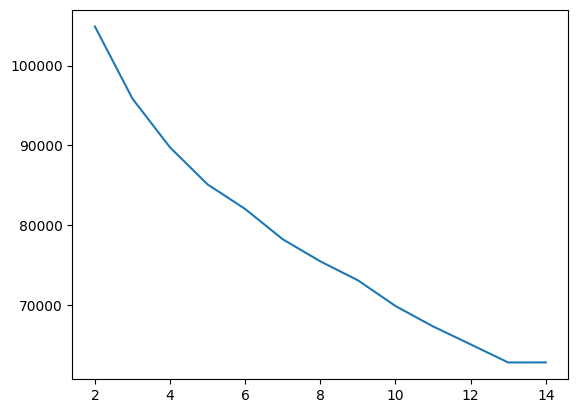

In [ ]:
# 스케일링
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
digits_scaled = ss.fit_transform(digits.data)

inertia = []
for k in range(2,15):
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(digits_scaled)
  inertia.append(km.inertia_)
plt.plot(range(2,15),inertia)
plt.show()

In [ ]:
# 클러스터의 개수는 4 or 8
km = KMeans(n_clusters=10, random_state=42)
km.fit(digits.data)
np.unique(km.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([193, 146, 181, 173, 166, 178, 173, 167, 172, 248]))

In [ ]:
km.labels_ == 0

array([False, False, False, ..., False, False, False])

In [ ]:
class_0 = digits.data[km.labels_ == 0]

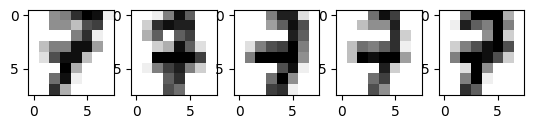

In [ ]:
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(class_0[i].reshape(8,8),cmap='gray_r')
plt.show()

In [ ]:
!unzip /content/drive/MyDrive/data/img/horse-or-human.zip -d data/

Archive:  /content/drive/MyDrive/data/img/horse-or-human.zip
  inflating: data/horses/horse01-0.png  
  inflating: data/horses/horse01-1.png  
  inflating: data/horses/horse01-2.png  
  inflating: data/horses/horse01-3.png  
  inflating: data/horses/horse01-4.png  
  inflating: data/horses/horse01-5.png  
  inflating: data/horses/horse01-6.png  
  inflating: data/horses/horse01-7.png  
  inflating: data/horses/horse01-8.png  
  inflating: data/horses/horse01-9.png  
  inflating: data/horses/horse02-0.png  
  inflating: data/horses/horse02-1.png  
  inflating: data/horses/horse02-2.png  
  inflating: data/horses/horse02-3.png  
  inflating: data/horses/horse02-4.png  
  inflating: data/horses/horse02-5.png  
  inflating: data/horses/horse02-6.png  
  inflating: data/horses/horse02-7.png  
  inflating: data/horses/horse02-8.png  
  inflating: data/horses/horse02-9.png  
  inflating: data/horses/horse03-0.png  
  inflating: data/horses/horse03-1.png  
  inflating: data/horses/horse03-2.pn

In [ ]:
from glob import glob
files = glob('/content/data/**/*.png',recursive=True)
print('총 파일개수',len(files))

총 파일개수 1027


In [ ]:
!pip install opencv-python

In [ ]:
import cv2
img = cv2.imread(files[100])  # 이미지 읽기(수치화)
img = cv2.resize(img,(64,64)) # 사이즈 조정
img = img.flatten()  # (12288,) 데이터 평탄화

In [ ]:
# 전체이미지 적용
from tqdm import tqdm
images = []
for file in tqdm(files):
  img = cv2.imread(file)  # 이미지 읽기(수치화)
  img = cv2.resize(img,(64,64)) # 사이즈 조정
  img = img.flatten() / 255.0 #  0 ~ 1 스케일링
  images.append(img)

100%|██████████| 1027/1027 [00:06<00:00, 167.63it/s]


In [ ]:
images = np.array(images)
km = KMeans(n_clusters=2, random_state=42)
km.fit(images)

KMeans(n_clusters=2, random_state=42)

In [ ]:
km.labels_[:3], files[:3]

(array([1, 1, 1], dtype=int32),
 ['/content/data/horses/horse28-4.png',
  '/content/data/horses/horse28-7.png',
  '/content/data/horses/horse33-1.png'])

In [ ]:
# 동일한 클러스터링끼리 같은 폴더로 이동
!mkdir horse

In [ ]:
!mkdir human

In [ ]:
np.unique(km.labels_,return_counts=True)

(array([0, 1], dtype=int32), array([394, 633]))

In [ ]:
len(km.labels_ == 0), len(files)

(1027, 1027)

In [ ]:
files = np.array(files)
len(files[km.labels_ == 0]), len(files[km.labels_ == 1])

(394, 633)

In [ ]:
# 파일 이동
# import shutil
# shutil.move(a,b)
import os
# os.rename(a,b)
for file in files[km.labels_ == 0]:
  os.rename(file,'horse/'+file.split('/')[-1])
for file in files[km.labels_ == 1]:
  os.rename(file,'human/'+file.split('/')[-1])


In [ ]:
glob('/content/data/**/*.png',recursive=True)

[]

In [ ]:
glob('/content/human/**/*.png',recursive=True)

['/content/human/horse28-4.png',
 '/content/human/horse28-7.png',
 '/content/human/human16-13.png',
 '/content/human/horse33-1.png',
 '/content/human/horse39-1.png',
 '/content/human/human06-09.png',
 '/content/human/human01-17.png',
 '/content/human/human01-08.png',
 '/content/human/horse34-7.png',
 '/content/human/human15-18.png',
 '/content/human/human10-14.png',
 '/content/human/human15-08.png',
 '/content/human/horse07-2.png',
 '/content/human/human05-04.png',
 '/content/human/human14-02.png',
 '/content/human/horse22-3.png',
 '/content/human/human08-30.png',
 '/content/human/horse38-6.png',
 '/content/human/horse27-3.png',
 '/content/human/human12-08.png',
 '/content/human/human14-15.png',
 '/content/human/human05-24.png',
 '/content/human/human03-09.png',
 '/content/human/human08-02.png',
 '/content/human/horse05-6.png',
 '/content/human/human08-12.png',
 '/content/human/human16-26.png',
 '/content/human/human10-18.png',
 '/content/human/human03-11.png',
 '/content/human/horse19

## 지도학습
```
정답이 있는경우
분류
회귀
```
## 비지도학습
```
정답이 없이 데이터의 특성을 이용해서 같은 그룹끼리 묶는
클러스터링
```